In [1]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_openai import AzureOpenAIEmbeddings
from langchain_community.vectorstores.azuresearch import AzureSearch
from langchain_text_splitters import RecursiveCharacterTextSplitter
import time
from datetime import datetime

In [2]:
import openai
import json
import os
from langchain.chat_models import AzureChatOpenAI
from langchain.schema import HumanMessage
from langchain import LLMChain


# Load config values
with open(r'config.json') as config_file:
    config_details = json.load(config_file)

# The base URL for your Azure OpenAI resource. e.g. "https://<your resource name>.openai.azure.com"
openai_api_base=config_details['OPENAI_API_BASE']
    
# API version e.g. "2023-07-01-preview"
openai_api_version=config_details['OPENAI_API_VERSION']

# The name of your Azure OpenAI deployment chat model.
deployment_name=config_details['DEPLOYMENT_NAME']

# The API key for your Azure OpenAI resource.
openai_api_key = "76d8b9f50e2945978ef0a01724d20d55"

# This is set to `azure`
openai_api_type="azure"

In [3]:
output_path = "./images"

In [4]:
# Get elements
raw_pdf_elements = partition_pdf(
    filename= r"C:\Users\Rithwik Khera\OneDrive - iitr.ac.in\Desktop\unstructured\bosch test.pdf" ,
    extract_images_in_pdf = True ,
    infer_table_structure = True ,
    chunking_strategy = "by_title" ,
    #starting_page_number = 2,
    max_characters = 4000 ,
    new_after_n_chars = 3800 ,
    combine_text_under_n_chars = 2000 ,
    extract_image_block_output_dir = output_path
)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
from langchain_openai import AzureChatOpenAI

# Get text summaries and table summaries
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
summary_chain = LLMChain(
    llm=AzureChatOpenAI(model=deployment_name,azure_endpoint=openai_api_base,openai_api_version=openai_api_version,openai_api_type=openai_api_type, openai_api_key = openai_api_key),
    prompt=PromptTemplate.from_template(summary_prompt)
)

for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)


c:\Users\Rithwik Khera\anaconda3\envs\unstructured\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
c:\Users\Rithwik Khera\anaconda3\envs\unstructured\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [6]:
text_summaries[5]

'The text outlines the degrees of protection and earthing contact classes for electric systems and appliances, based on standards such as DIN 40 050 and DIN VDE 0720. The protection classes depend on the construction and lineup of the systems and appliances to prevent risks from contact with live parts and the ingress of foreign bodies and water. Protection classes include:\n\n- **Protection Class I**: Requires a protective conductor.\n- **Protection Class II**: Involves total insulation.\n- **Protection Class III**: Uses protective low voltage (max 50V).\n\nIP degrees of protection vary, including:\n\n- **IP 05**: Protection against dust.\n- **IP 06**: Dust-proof protection.\n- **IP 31 to IP 68**: Ranging from protection against dripping water to proof against water under pressure.\n\n**Protective earthing** ensures all metal parts a user might touch are connected to a protective conductor to prevent electric shock if damage occurs. This requires the protective conductor to be adequat

In [7]:
# Get image summaries
image_elements = []
image_summaries = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def summarize_image(encoded_image):
    prompt = [
        SystemMessage(content="You are a bot that is good at analyzing images related to safety in relation to Power Tools and its Applications."),
        HumanMessage(content=[
            {
                "type": "text",
                "text": "Describe the contents of this image."
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = AzureChatOpenAI(model=deployment_name,openai_api_version=openai_api_version,azure_endpoint=openai_api_base, openai_api_key=openai_api_key).invoke(prompt)
    return response.content

for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
        summary = summarize_image(encoded_image)
        image_summaries.append(summary)


In [8]:
image_summaries[20]

'The image depicts a line drawing of an electric power drill being held in both hands. The drill has a pistol-grip style handle. One hand is gripping the main handle of the drill, while the other hand is holding a side handle. Two measurements are indicated on the image:\n\n1. Measurement "A" is shown vertically from the bottom of the side handle to the top of the drill.\n2. Measurement "B" is shown vertically from the highest point on the drill to the lowest point on the drill\'s main handle.\n\nThese measurements likely correspond to specific dimensions or clearances related to the tool\'s use or ergonomics.'

In [9]:
# Create Documents and Vectorstore
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    doc = Document(
        page_content = str(s),
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

#generating embeddings
embeddings = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-ada-002",
    openai_api_version="2023-05-15",
    azure_endpoint=openai_api_base,
)

#text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=10)
#text_splitter.split_text(documents)

#loading faiss vector database
vectorstore = FAISS.from_documents(documents=documents, embedding=embeddings)

In [10]:
vectorstore.save_local("faiss_index2")

In [31]:
prompt_template = """
You are an expert in safety in relation to Power Tools and their Applications.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [32]:
qa_chain = LLMChain(llm=AzureChatOpenAI(model="gpt-4o", openai_api_key = openai_api_key,api_version=openai_api_version,azure_endpoint=openai_api_base ,max_tokens=1024),
                        prompt=PromptTemplate.from_template(prompt_template))

In [13]:
qa_chain

LLMChain(prompt=PromptTemplate(input_variables=['context', 'question'], template='\nYou are an expert in safety in relation to Power Tools and their Applications.\nAnswer the question based only on the following context, which can include text, images and tables:\n{context}\nQuestion: {question}\nDon\'t answer if you are not sure and decline to answer and say "Sorry, I don\'t have much information about it."\nJust return the helpful answer in as much as detailed possible.\nAnswer:\n'), llm=AzureChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x000001F28197D540>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x000001F28197E980>, model_name='gpt-4o', openai_api_key=SecretStr('**********'), openai_proxy='', max_tokens=1024, azure_endpoint='https://heybosch-dev-openai.openai.azure.com/', openai_api_version='2024-02-01', openai_api_type='azure'))

In [22]:
#def answer(question):
    #relevant_docs = vectorstore.similarity_search(question)
    #context = ""
    #relevant_images = []
    #for d in relevant_docs:
        #if d.metadata['type'] == 'text':
            #context += '[text]' + d.metadata['original_content']
        #elif d.metadata['type'] == 'table':
            #context += '[table]' + d.metadata['original_content']
        #elif d.metadata['type'] == 'image':
            #context += '[image]' + d.page_content
            #relevant_images.append(d.metadata['original_content'])
    #result = qa_chain.run({'context': context, 'question': question})
    #return result, relevant_images

In [39]:
def answer(question):
    # the similarity search takes a constant time of 2 seconds for every case
    relevant_docs = vectorstore.similarity_search(question, k=10)
    
    # from the next line till the end of for loop takes 0 seconds for every case
    context = ""
    relevant_images = []
    for d,score in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])

    # the llm chain(qa_chain) takes the maximum amount of time and it takes a different times for different questions(6 secs - full in, 9 secs- rotary hammer) 
    result = qa_chain.run({'context': context, 'question': question})

    #the last line here takes 0 seconds in all the cases
    return result, relevant_images

In [1]:
#taking image as input 
#from PIL import Image
#import tkinter as tk
#from tkinter import filedialog

#def open_image():
    # Open file dialog
    #file_path = filedialog.askopenfilename(
    #    filetypes=[("Image files", "*.jpg;*.jpeg;*.png;*.bmp;*.gif")]
    #)

    # Check if a file was selected
    #if file_path:
    #    # Open and display the image
    #    image = Image.open(file_path)
    #    image.show()

# Set up the Tkinter root window
#root = tk.Tk()
#root.withdraw()  # Hide the root window

# Open image file dialog and display the selected image
#open_image()


4
Routing involves the use of a power tool called a router to hollow out or shape areas in wood, plastic, or other materials. The router is equipped with a rotating cutting tool, known as a router bit, which spins at high speeds to remove material. There are two primary types of routing techniques illustrated in the diagrams: upcut routing and downcut routing.

**Upcut Routing:**
- The router bit rotates in a counterclockwise direction.
- The material is fed in the opposite direction to the rotation of the bit, resulting in the removal of material in an upward direction.
- This technique is generally safer and easier to control, particularly when trimming edges, as it minimizes the risk of kickback and deflective motion.

**Downcut Routing:**
- The router bit rotates in a clockwise direction.
- The material is fed in the same direction as the rotation of the bit, resulting in the removal of material in a downward direction.
- This method can be more challenging to control, especially w

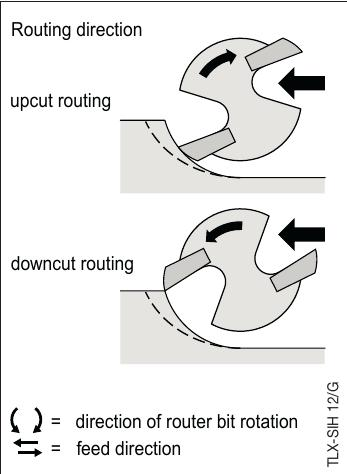

In [35]:
# Display result
question = "What is routing?"
relevant_docs = vectorstore.similarity_search_with_score(question)
print(len(relevant_docs))
temp=-1.00
context = ""
relevant_images = []
#print(relevant_docs[0])
for d,score in relevant_docs:
#for d in relevant_docs:
    if d.metadata['type'] == 'text':
        #print(score, "text", d.metadata['original_content'], end='\n')
        context += '[text]' + d.metadata['original_content']
    elif d.metadata['type'] == 'table':
        #print(score, "table", d.metadata['original_content'], end='\n')
        context += '[table]' + d.metadata['original_content']
    elif d.metadata['type'] == 'image':
        context += '[image]' + d.page_content
        #print(score, "image", end='\n')
        if temp==-1.00:
            relevant_images.append(d.metadata['original_content'])
            temp=score
        elif score < 0.4:
            relevant_images.append(d.metadata['original_content'])
        elif score < temp:
            relevant_images.append(d.metadata['original_content'])
            temp=score

#print(context)
result = qa_chain.run({'context': context, 'question': question})
print(result)
for e in relevant_images:
    display.display(display.Image(base64.b64decode(e)))

Total insulation refers to a safety feature in electric appliances where all electric parts of the appliance are insulated inside the housing, in addition to the basic safety insulation. This means that the internal electric components are surrounded by insulation that prevents any electrical contact with external touchable metal parts, such as the drive shaft in power tools. 

In the case of a defect in the basic safety insulation, this additional layer of insulation ensures that the damage remains confined to the internal electric components and does not reach the exterior of the appliance. Consequently, the connection of a protective conductor is no longer necessary. This design minimizes the risk of electric shock to the user, as any electrical fault remains contained within the appliance's housing.

The concept of total insulation is visually represented in diagrams of electric motors, where insulation surrounds key components like the armature (motor) shaft, commutator, windings,

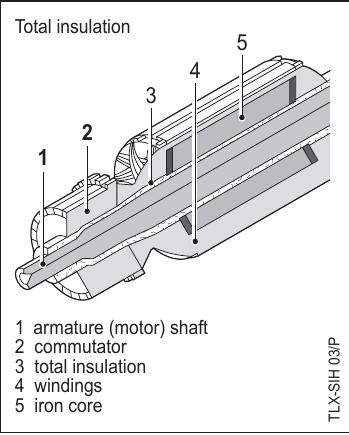

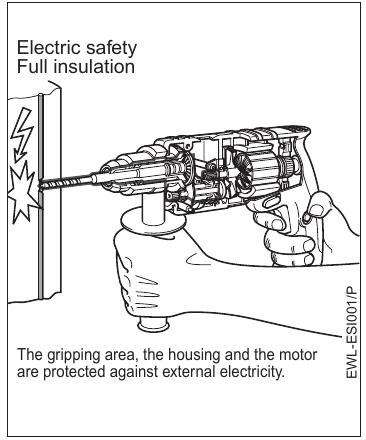

In [40]:
# Display result
result, relevant_images = answer("What is total insulation")
print(result)
for e in relevant_images:
    display.display(display.Image(base64.b64decode(e)))

Drilling is a process involving the use of a drill to create holes in a material. The drill bit, which is attached to the drill, rotates to cut into the material, forming a hole of a specific size and depth. Drilling is commonly used in various materials, including wood, metal, and plastic. 

The main hazards during drilling include restoring torques, which occur due to high friction between the drill bit and the material. These restoring torques can become dangerous if the drill bit jams or is withdrawn improperly, potentially causing the drill to suddenly generate very high and dangerous torques. 

To mitigate these risks, it is important to use sharp, well-maintained drill bits, support chip clearance by regularly withdrawing the bit during deep hole drilling, select appropriate speeds for large-diameter holes, and securely clamp the workpiece. Additionally, proper ergonomic handling by using both hands and auxiliary handles when available helps in controlling the torque forces and 

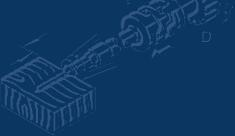

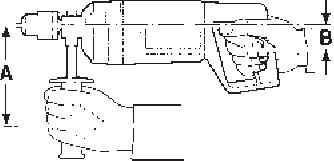

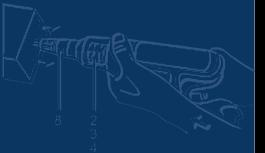

In [42]:
# Display result
result, relevant_images = answer("What is drilling")
print(result)
for e in relevant_images:
    display.display(display.Image(base64.b64decode(e)))

Electrical safety is defined as the protection of the users of electrical equipment against the hazards of electric shock. This involves preventing electricity from reaching the operator through the handle or other parts of the tool, especially if the application tool comes into contact with live wires or other conductive objects. This is crucial to avoid risks through inadvertent contact with conductive parts, such as drilling into live wires concealed under plasterwork.


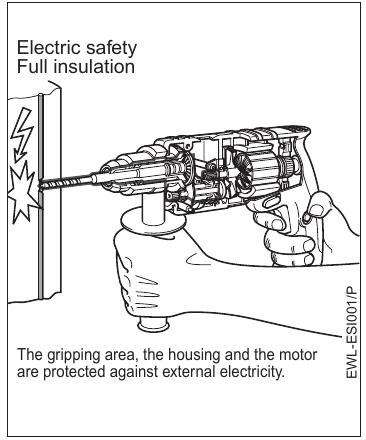

In [41]:
result, relevant_images = answer("What is the definition of electrical safety")
print(result)
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [2]:
import torch
print(torch.__version__)

2.3.0+cu118
